In [8]:
import math
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm.notebook import tqdm

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining the model

In [10]:
class VGG11(nn.Module):
    def conv_block(
        self,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=nn.ReLU(),
        max_pooling=nn.MaxPool2d(2, 2),
    ):
        layers = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size, stride, padding),
            nn.LazyBatchNorm2d(),
        )

        if activation is not None:
            layers.add_module("activation", activation)
        if max_pooling is not None:
            layers.add_module("max_pooling", max_pooling)
        return layers

    def linear_block(self, out_features, activation=nn.ReLU(), dropout=nn.Dropout(0.5)):
        layers = nn.Sequential(
            nn.LazyLinear(out_features),
            nn.LazyBatchNorm1d(),
        )

        if activation is not None:
            layers.add_module("activation", activation)
        if dropout is not None:
            layers.add_module("dropout", dropout)
        return layers

    def __init__(self):
        super(VGG11, self).__init__()

        self.layers = nn.Sequential(
            self.conv_block(64),
            self.conv_block(128),
            self.conv_block(256, max_pooling=None),
            self.conv_block(256),
            self.conv_block(512, max_pooling=None),
            self.conv_block(512),
            self.conv_block(512, max_pooling=None),
            self.conv_block(512),
            nn.Flatten(),
            self.linear_block(4096),
            self.linear_block(4096),
            self.linear_block(10, activation=None, dropout=None),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

## Loading the datasets

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.Lambda(lambda x: x + torch.randn_like(x)
                                              * math.sqrt(0.1))], p=0.2),
    transforms.RandomApply([transforms.Lambda(lambda x: x + torch.randn_like(x)
                                              * math.sqrt(1))], p=0.2),
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

## Helper function to train and evaluate the model

In [14]:
def train_and_evaluate(net, device, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    since = time.time()
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        tk0 = tqdm(train_loader, total=len(train_loader))
        for i, (images, labels) in enumerate(tk0):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            tk0.set_postfix(loss=(running_loss / (i + 1)))
        
        train_loss, training_accuracy = test(net, device, criterion, train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(training_accuracy)

        test_loss, test_accuracy = test(net, device, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {training_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return train_losses, train_accuracies, test_losses, test_accuracies

# returns accuracy on data_loader and loss
def test(net, device, criterion, data_loader):
    net.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += images.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(data_loader), correct / total

## Training the model

In [17]:
net = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.01)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(net, device, optimizer, criterion, train_loader, test_loader, 5)
torch.save(net.state_dict(), "model.bin")

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.6379, Train Accuracy: 0.7936, Test Loss: 1.3898, Test Accuracy: 0.6197


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.3357, Train Accuracy: 0.8958, Test Loss: 0.2656, Test Accuracy: 0.9206


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.3116, Train Accuracy: 0.9047, Test Loss: 0.2817, Test Accuracy: 0.9170


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.2646, Train Accuracy: 0.9170, Test Loss: 0.1607, Test Accuracy: 0.9521


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.2310, Train Accuracy: 0.9257, Test Loss: 0.1118, Test Accuracy: 0.9651
Training complete in 3m 52s


## Plotting accuracy and loss over time

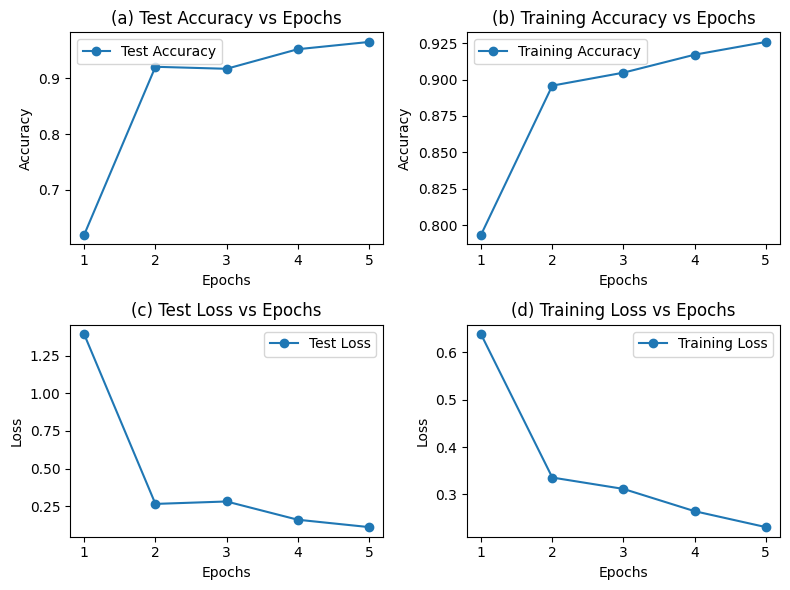

In [18]:
epochs = range(1, len(train_accuracies) + 1)
    
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
plt.title('(a) Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'o-', label='Training Accuracy')
plt.title('(b) Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, test_losses, 'o-', label='Test Loss')
plt.title('(c) Test Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.title('(d) Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.show()